# 3D Constructive Solid Geometry (CSG) with GeoLIPI

This notebook showcases the use of GeoLIPI for Constructive Solid Geometry (CSG) in three dimensions (3D).

In [88]:
import sys
sys.path.append('../')

import numpy as np
import torch as th
import matplotlib.pyplot as plt

import geolipi.symbolic as gls
from geolipi.torch_compute.sphere_marcher import Renderer

dtype = th.float32
device = th.device("cuda")
resolution = (512, 256)

In [89]:
# Just use the default settings in the renderer
renderer = Renderer(resolution=resolution, dtype=dtype, device=device)


Union(
	Translate3D(
		Scale3D(
			Difference(
				RoundedBox3D(tensor([0.5000, 0.5000, 0.5000], device='cuda:0'), tensor(0.3000, device='cuda:0')),
				Union(
					Box3D(tensor([1.2000, 0.8100, 0.5000], device='cuda:0')),
					Box3D(tensor([0.5000, 0.8100, 1.2000], device='cuda:0')))),
			tensor([0.6000, 0.6000, 0.6000], device='cuda:0')),
		tensor([0.0000, 0.3000, 0.0000], device='cuda:0')),
	Translate3D(
		EulerRotate3D(
			EulerRotate3D(
				Union(
					BoxFrame3D(tensor([0.5000, 0.6000, 0.1000], device='cuda:0'), tensor([0.0200], device='cuda:0')),
					Rhombus3D(tensor(0.4000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor([0.0500], device='cuda:0'), tensor([0.1000], device='cuda:0'))),
				tensor([0.0000, 1.5708, 0.0000], device='cuda:0')),
			tensor([0.0000, 0.0000, 0.3142], device='cuda:0')),
		tensor([-0.5000, -0.7000,  0.0000], device='cuda:0')),
	EulerRotate3D(
		Union(
			CutSphere3D(tensor(0.5000, device='cuda:0'), tensor(0.2000, device='cuda:0')),
			Scale3D(


(-0.5, 511.5, 255.5, -0.5)

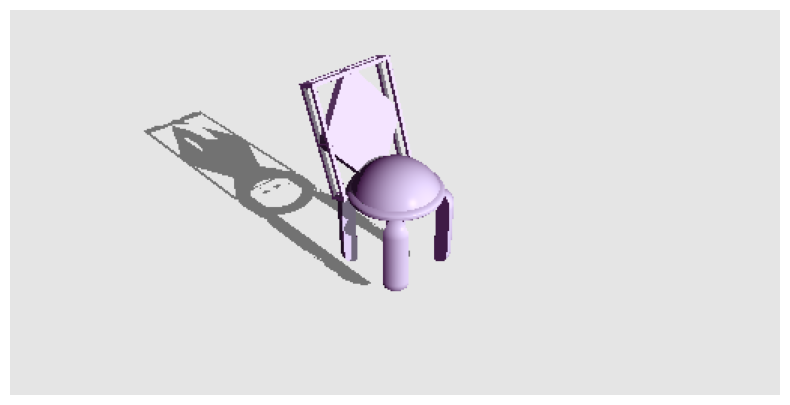

In [94]:
# Simple CSG Expressions for a chair

chair_legs = gls.Difference(
    gls.RoundedBox3D((0.5, 0.5, 0.5), (0.3)),
    gls.Union(
        gls.Box3D((1.2, 0.81, .5)),
        gls.Box3D((0.5, 0.81, 1.2)),
    )
)
chair_seat = gls.EulerRotate3D(gls.Union(
    gls.CutSphere3D((0.5), (0.2)),
    gls.Scale3D(
        gls.Capsule3D((0.0, 0, 0.9), (0.0, 0, 0.8), (0.5,)),
        (1.0, 1.0, 0.2))
    ), (-np.pi/2, 0, 0))

chair_back = gls.EulerRotate3D(gls.Union(
    gls.BoxFrame3D((0.5, 0.6, 0.1), (0.02,)),
    gls.Rhombus3D((0.4), (0.5), (0.05,), (0.1,))
    ), (0, np.pi/2, 0))

expr = gls.Union(
        gls.Translate3D(
            gls.Scale3D(
                chair_legs, (0.6, 0.6, 0.6)
                ), (0., 0.3, 0.)
            ), 
        gls.Translate3D(
            gls.EulerRotate3D(
                chair_back, (0, 0, np.pi/10)
            ), (-0.5, -0.7, 0.)
        ),
        chair_seat)

expr = expr.to_tensor().cuda()
print(expr.pretty_print())
image = renderer.render(expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

SmoothUnion(
	Translate3D(
		Scale3D(
			SmoothDifference(
				RoundedBox3D(tensor([0.5000, 0.5000, 0.5000], device='cuda:0'), tensor(0.3000, device='cuda:0')),
				SmoothUnion(
					Box3D(tensor([1.2000, 0.8100, 0.5000], device='cuda:0')),
					Box3D(tensor([0.5000, 0.8100, 1.2000], device='cuda:0')),
					tensor([0.1000], device='cuda:0')),
				tensor([0.1000], device='cuda:0')),
			tensor([0.6000, 0.6000, 0.6000], device='cuda:0')),
		tensor([0.0000, 0.3000, 0.0000], device='cuda:0')),
	SmoothUnion(
		Translate3D(
			EulerRotate3D(
				EulerRotate3D(
					SmoothUnion(
						BoxFrame3D(tensor([0.5000, 0.6000, 0.1000], device='cuda:0'), tensor([0.0200], device='cuda:0')),
						Rhombus3D(tensor(0.4000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor([0.0500], device='cuda:0'), tensor([0.1000], device='cuda:0')),
						tensor([0.1000], device='cuda:0')),
					tensor([0.0000, 1.5708, 0.0000], device='cuda:0')),
				tensor([0.0000, 0.0000, 0.3142], device='cuda:0')),
			tensor(

(-0.5, 511.5, 255.5, -0.5)

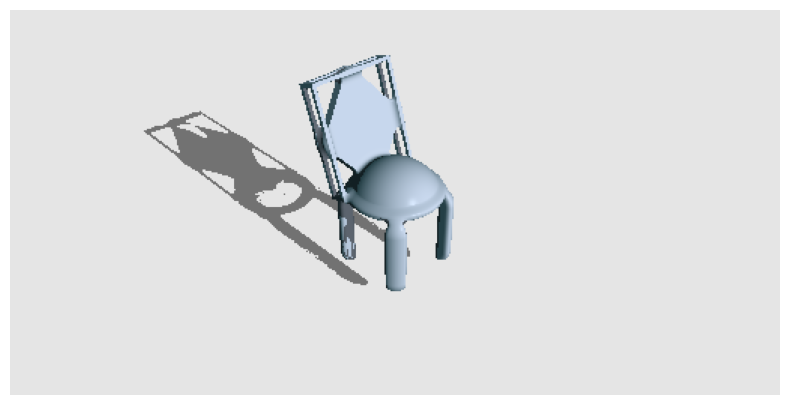

In [91]:
# New Modifiers 
# Smooth Modifier
# Simple CSG Expressions for a chair
k = (0.1,)
chair_legs = gls.SmoothDifference(
    gls.RoundedBox3D((0.5, 0.5, 0.5), (0.3)),
    gls.SmoothUnion(
        gls.Box3D((1.2, 0.81, .5)),
        gls.Box3D((0.5, 0.81, 1.2)),
        k
    ), k)
chair_seat = gls.EulerRotate3D(gls.SmoothUnion(
    gls.CutSphere3D((0.5), (0.2)),
    gls.Scale3D(
        gls.Capsule3D((0.0, 0, 0.9), (0.0, 0, 0.8), (0.5,)),
        (1.0, 1.0, 0.2)), k
    ), (-np.pi/2, 0, 0))

chair_back = gls.EulerRotate3D(gls.SmoothUnion(
    gls.BoxFrame3D((0.5, 0.6, 0.1), (0.02,)),
    gls.Rhombus3D((0.4), (0.5), (0.05,), (0.1,)), k
    ), (0, np.pi/2, 0))

expr = gls.SmoothUnion(
        gls.Translate3D(
            gls.Scale3D(
                chair_legs, (0.6, 0.6, 0.6)
                ), (0., 0.3, 0.)
            ), 
        gls.SmoothUnion(
        gls.Translate3D(
            gls.EulerRotate3D(
                chair_back, (0, 0, np.pi/10)
            ), (-0.5, -0.7, 0.)
        ),
        chair_seat, k), k)

expr = expr.to_tensor().cuda()
print(expr.pretty_print())
image = renderer.render(expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


Union(
	Translate3D(
		Scale3D(
			Difference(
				RoundedBox3D(tensor([0.5000, 0.5000, 0.5000], device='cuda:0'), tensor(0.3000, device='cuda:0')),
				Union(
					Box3D(tensor([1.2000, 0.8100, 0.5000], device='cuda:0')),
					Box3D(tensor([0.5000, 0.8100, 1.2000], device='cuda:0')))),
			tensor([0.6000, 0.6000, 0.6000], device='cuda:0')),
		tensor([0.0000, 0.3000, 0.0000], device='cuda:0')),
	Translate3D(
		EulerRotate3D(
			Bend3D(
				EulerRotate3D(
					Union(
						BoxFrame3D(tensor([0.5000, 0.6000, 0.1000], device='cuda:0'), tensor([0.0200], device='cuda:0')),
						Rhombus3D(tensor(0.4000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor([0.0500], device='cuda:0'), tensor([0.1000], device='cuda:0'))),
					tensor([1.5708, 0.0000, 0.0000], device='cuda:0')),
				tensor([1.5000], device='cuda:0')),
			tensor([-1.5708,  1.5708,  0.0000], device='cuda:0')),
		tensor([-0.5000, -0.7000,  0.0000], device='cuda:0')),
	EulerRotate3D(
		Union(
			CutSphere3D(tensor(0.5000, devic

(-0.5, 511.5, 255.5, -0.5)

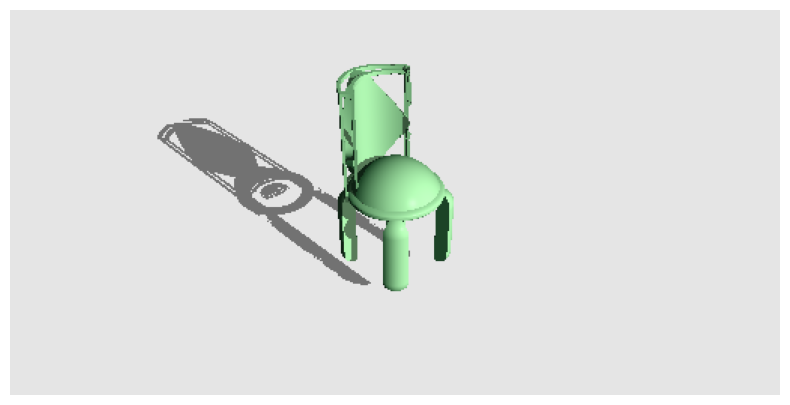

In [95]:
# New Modifiers 
# Bend

# Simple CSG Expressions for a chair


chair_back = gls.EulerRotate3D(
        gls.Bend3D(
            gls.EulerRotate3D(gls.Union(
        gls.BoxFrame3D((0.5, 0.6, 0.1), (0.02,)),
        gls.Rhombus3D((0.4), (0.5), (0.05,), (0.1,))
    ), (np.pi/2, 0, 0)), 
    (1.5,)), (-np.pi/2, np.pi/2, 0))

expr = gls.Union(
        gls.Translate3D(
            gls.Scale3D(
                chair_legs, (0.6, 0.6, 0.6)
                ), (0., 0.3, 0.)
            ), 
        gls.Translate3D(
                chair_back, (-0.5, -0.7, 0.)
        ),
        chair_seat)
# expr = chair_back
expr = expr.to_tensor().cuda()
print(expr.pretty_print())
image = renderer.render(expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

Translate3D(
	Union(
		RotationSymmetryY3D(
			Translate3D(
				Scale3D(
					Union(
						Translate3D(
							Scale3D(
								Difference(
									RoundedBox3D(tensor([0.5000, 0.5000, 0.5000], device='cuda:0'), tensor(0.3000, device='cuda:0')),
									Union(
										Box3D(tensor([1.2000, 0.8100, 0.5000], device='cuda:0')),
										Box3D(tensor([0.5000, 0.8100, 1.2000], device='cuda:0')))),
								tensor([0.6000, 0.6000, 0.6000], device='cuda:0')),
							tensor([0.0000, 0.3000, 0.0000], device='cuda:0')),
						Translate3D(
							EulerRotate3D(
								Bend3D(
									EulerRotate3D(
										Union(
											BoxFrame3D(tensor([0.5000, 0.6000, 0.1000], device='cuda:0'), tensor([0.0200], device='cuda:0')),
											Rhombus3D(tensor(0.4000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor([0.0500], device='cuda:0'), tensor([0.1000], device='cuda:0'))),
										tensor([1.5708, 0.0000, 0.0000], device='cuda:0')),
									tensor([1.5000], device='cuda:0')),
							

(-0.5, 511.5, 255.5, -0.5)

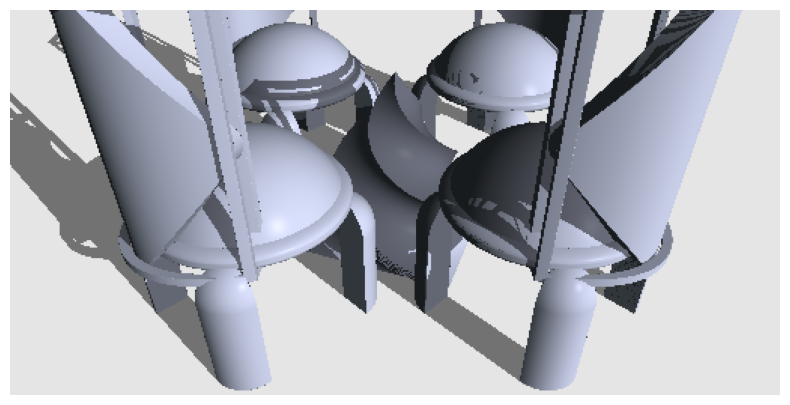

In [97]:
# Macros

chair_expr = gls.Scale3D(gls.Union(
        gls.Translate3D(
            gls.Scale3D(
                chair_legs, (0.6, 0.6, 0.6)
                ), (0., 0.3, 0.)), 
        gls.Translate3D(
                chair_back, (-0.5, -0.7, 0.)),
        chair_seat), (2.0, 2.0, 2.0))

chair_set = gls.RotationSymmetryY3D(
    gls.Translate3D(chair_expr, (-2, 0, 0)), 
    (np.pi/2,), 4)

table = gls.Scale3D(
        gls.EulerRotate3D(
            gls.Twist3D(
                gls.Pyramid3D((1.0,)), 
            (4.0)),  
        (-np.pi/2, 0, 0)),
    (2, 2, 2))

# expr = chair_back
scene = gls.Translate3D(gls.Union(
    chair_set, table), (-0.75, 0, 0.75))
expr = scene.to_tensor().cuda()
print(expr.pretty_print())
image = renderer.render(expr, convergence_threshold=1e-30)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')